In [ ]:
"""
This notebook takes 
1. a stack, 
2. a pair of neurotrace blue and nissl sections and 
3. a bounding box for a region of interest,
generates the intensity histograms, mapping curve and corresponding images.
"""

In [1]:
import os, sys

from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Precision WorkStation


No vtk
No vtkNot using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.
Not using image_cache.


In [2]:
from skimage.exposure import rescale_intensity

In [3]:
def match_histogram(source, template):
    """
    Returns: 
        s_values (array): unique source values
        interp_t_values (array): unique destination values
    """
    
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return s_values, interp_t_values

In [4]:
def normalize_image(img, region_size = 1000, region_spacing = 100):
    
    img_calib = np.zeros(img.shape, np.float)

    for cx in range(region_size, img.shape[1]-region_size, region_spacing):
        for cy in range(region_size, img.shape[0]-region_size, region_spacing):
    #         mu, std = mean_std_sample_locations[(cx, cy)]
            mu = img[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1].mean()
            std = img[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1].std()
            if std > 0:            
    #             img_calib[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1] = \
    #             .5 * img_calib[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1] + \
    #             .5 * (img[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1] - mu) / std
                img_calib[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1] = \
                (img[cy-region_size/2:cy+region_size/2+1, cx-region_size/2:cx+region_size/2+1] - mu) / std
    return img_calib

# margin = 500
# img_calib = normalize_image(ntb_im[region_y-margin:region_y+region_h+margin, 
#                                    region_x-margin:region_x+region_w+margin,
#                                   2])[margin:-margin, margin:-margin]
# img_calib_ubyte = rescale_intensity_v2(img_calib, 6, -1)

In [5]:
stack = 'MD658'

In [6]:
nissl_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                  for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'N']
ntb_sections = [metadata_cache['filenames_to_sections'][stack][fn] 
                for fn in metadata_cache['valid_filenames'][stack] if fn.split('-')[1][0] == 'F']

In [8]:
filename_pairs = []
for nissl_sec in nissl_sections:
    for i in range(1, 99):
        closest_ntb_sec = nissl_sec + i
        if closest_ntb_sec in ntb_sections or closest_ntb_sec > metadata_cache['section_limits'][stack][1]:
            break
    if metadata_cache['sections_to_filenames'][stack][closest_ntb_sec].split('-')[1][0] == 'F':
        filename_pairs.append((metadata_cache['sections_to_filenames'][stack][nissl_sec], 
                               metadata_cache['sections_to_filenames'][stack][closest_ntb_sec]))

In [10]:
mapping_all_regions_all_sections = {}
mapping2_all_regions_all_sections = {}
region_bboxes_all_regions_all_sections = {}

for nissl_fn, ntb_fn in filename_pairs[:10]:
    
    ntb_matched_values_all_examples_one_section = []
    ntb2_matched_values_all_examples_one_section = []
    region_bboxes_all_examples_one_section = []
    
    nissl_tb_mask = DataManager.load_thumbnail_mask_v3(stack=stack, fn=nissl_fn, prep_id=2)
    w, h = metadata_cache['image_shape'][stack]

    t = time.time()
    ntb_im = DataManager.load_image_v2(stack=stack, fn=ntb_fn, prep_id=2,  resol='lossless')[...,2]
    sys.stderr.write('Load NTB: %.2f seconds.\n' % (time.time()-t))

    t = time.time()
    nissl_im = DataManager.load_image_v2(stack=stack, fn=nissl_fn, prep_id=2, resol='lossless')
    sys.stderr.write('Load Nissl: %.2f seconds.\n' % (time.time()-t))

    margin = 500

    h, w = nissl_im.shape[:2]
    for region_id in range(5):
        while True:
            region_w = 5000
            region_h = 5000
            region_x = np.random.randint(margin, w - region_w - margin, 1)[0]
            region_y = np.random.randint(margin, h - region_h - margin, 1)[0]
#             print region_x, region_y, region_w, region_h
            
            tb_region_xmin = region_x / 32
            tb_region_xmax = (region_x + region_w) / 32
            tb_region_ymin = region_y / 32
            tb_region_ymax = (region_y + region_h) / 32
            
            if np.all(np.r_[nissl_tb_mask[tb_region_ymin, tb_region_xmin],
            nissl_tb_mask[tb_region_ymin, tb_region_xmax],
            nissl_tb_mask[tb_region_ymax, tb_region_xmin],
            nissl_tb_mask[tb_region_ymax, tb_region_xmax]]):
                break
    
    
        t = time.time()
        img_calib = normalize_image(ntb_im[region_y-margin:region_y+region_h+margin, 
                                           region_x-margin:region_x+region_w+margin],
                                   region_size=1000, 
                                   region_spacing=500)[margin:-margin, margin:-margin]
        img_calib_ubyte = rescale_intensity_v2(img_calib, 6, -1)
        ntb_blue_region = img_calib_ubyte
        sys.stderr.write('Calibrate image: %.2f seconds.\n' % (time.time()-t))

#     for region_id in range(1):
#         region_x = 233 * 32
#         region_y = 299 * 32
#         region_w = 124 * 32
#         region_h = 98 * 32
    
        ntb2_blue_region = ntb_im[region_y:region_y+region_h, region_x:region_x+region_w]
        
        # Checked a few sections, maximal intensity value in blue channel is less than 5000.
#         ntb_blue_bins = np.arange(5001)
#         ntb_blue_hist = np.histogram(ntb_blue_region.flatten(), bins=np.r_[ntb_blue_bins, 5001])[0]
        
#         ntb_blue_inv_bins = np.arange(5001)
#         ntb_blue_inv_hist = np.histogram(5000 - ntb_blue_region.flatten(), bins=np.r_[ntb_blue_inv_bins, 5001])[0]
 
        nissl_region = img_as_ubyte(rgb2gray(nissl_im[region_y:region_y+region_h, region_x:region_x+region_w]))
#         nissl_gray_bins = np.arange(0, 257)
#         nissl_gray_hist = np.histogram(nissl_region.flatten(), bins=nissl_gray_bins)[0]        

        ###############

        t = time.time()

# If need inverse
        
        ntb2_blue_region_inv = 5000 - ntb2_blue_region.astype(np.int)
        ntb2_inv_vals, nissl_vals = match_histogram(ntb2_blue_region_inv, nissl_region)

        ntb2_blue_bins = np.arange(5001)
        ntb2_blue_inv_bins = np.arange(0, 5001)
        ntb2_inv_to_nissl_mapping = np.interp(ntb2_blue_inv_bins, ntb2_inv_vals, nissl_vals)
        ntb2_to_nissl_mapping = ntb2_inv_to_nissl_mapping[5000 - ntb2_blue_bins]
        ntb2_to_nissl_mapping = np.round(ntb2_to_nissl_mapping).astype(np.uint8)
        
        ntb2_matched_values_all_examples_one_section.append(ntb2_to_nissl_mapping)

# If do not need inverse

        ntb_vals, nissl_vals = match_histogram(ntb_blue_region.astype(np.int), nissl_region)

        ntb_blue_bins = np.arange(0, 256)
        ntb_to_nissl_mapping = np.interp(ntb_blue_bins, ntb_vals, nissl_vals)
                
        ntb_matched_values_all_examples_one_section.append(ntb_to_nissl_mapping)
        region_bboxes_all_examples_one_section.append((region_x, region_y, region_w, region_h))
    
        sys.stderr.write('Compute matching: %.2f seconds.\n' % (time.time()-t))
        
#         ntb_region_normalized = np.round(ntb_to_nissl_mapping[ntb_blue_region]).astype(np.uint8)
        
#         ntb_blue_normalized_bins = np.arange(0, 256)
#         ntb_blue_normalized_hist = np.histogram(ntb_region_normalized.flatten(), bins=np.r_[ntb_blue_normalized_bins, [257]])[0]
        
#         # Linear normalization
        
#         low = 2500
#         high = 0
#         if low > high:
#             ntb_region_linearNormalized_inverted = rescale_intensity(low-ntb_blue_region.astype(np.int), (0, low-high), (0, 255)).astype(np.uint8)
#         else:
#             ntb_region_linearNormalized_inverted = rescale_intensity(ntb_blue_region.astype(np.int), (low, high), (0, 255)).astype(np.uint8)
#         ntb_blue_linearNormalized_inverted_bins = np.arange(0, 256)
#         ntb_blue_linearNormalized_inverted_hist = np.histogram(ntb_region_linearNormalized_inverted.flatten(), bins=np.r_[ntb_blue_linearNormalized_inverted_bins, [257]])[0]
        
#         # Linear normalization
#         low = 0
#         high = 2500
#         ntb_region_linearNormalized = rescale_intensity(ntb_blue_region.astype(np.int), (low, high), (0, 255)).astype(np.uint8)        
#         ntb_blue_linearNormalized_bins = np.arange(0, 256)
#         ntb_blue_linearNormalized_hist = np.histogram(ntb_region_linearNormalized.flatten(), bins=np.r_[ntb_blue_linearNormalized_bins, [257]])[0]
        
#         ntb_to_nissl_linear_mapping = np.zeros((5001,))
#         ntb_to_nissl_linear_mapping[:high] = - 255 / float(high) * np.arange(high) + 255
        
    mapping_all_regions_all_sections[(nissl_fn, ntb_fn)] = ntb_matched_values_all_examples_one_section
    mapping2_all_regions_all_sections[(nissl_fn, ntb_fn)] = ntb2_matched_values_all_examples_one_section
    region_bboxes_all_regions_all_sections[(nissl_fn, ntb_fn)] = region_bboxes_all_examples_one_section 

Not using image_cache.
Load NTB: 13.30 seconds.
Not using image_cache.
Load Nissl: 8.98 seconds.
Calibrate image: 1.46 seconds.
Compute matching: 8.11 seconds.
Calibrate image: 1.44 seconds.
Compute matching: 7.94 seconds.
Calibrate image: 1.44 seconds.
Compute matching: 7.99 seconds.
Calibrate image: 1.44 seconds.
Compute matching: 7.99 seconds.
Calibrate image: 1.43 seconds.
Compute matching: 8.18 seconds.
Not using image_cache.
Load NTB: 12.51 seconds.
Not using image_cache.
Load Nissl: 8.81 seconds.
Calibrate image: 1.48 seconds.
Compute matching: 7.99 seconds.
Calibrate image: 1.37 seconds.
Compute matching: 7.83 seconds.
Calibrate image: 1.36 seconds.
Compute matching: 7.78 seconds.
Calibrate image: 1.36 seconds.
Compute matching: 7.78 seconds.
Calibrate image: 1.35 seconds.
Compute matching: 7.62 seconds.
Not using image_cache.
Load NTB: 14.39 seconds.
Not using image_cache.
Load Nissl: 8.61 seconds.
Calibrate image: 1.41 seconds.
Compute matching: 7.89 seconds.
Calibrate image:

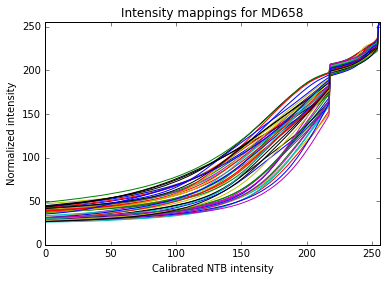

In [13]:
plt.plot(ntb_blue_bins, np.concatenate(mapping_all_regions_all_sections.values()).T);
plt.xlabel('Calibrated NTB intensity');
plt.ylabel('Normalized intensity');
plt.ylim([0,256]);
plt.xlim([0,256]);
plt.title('Intensity mappings for %s' % stack);
plt.legend();
plt.show();

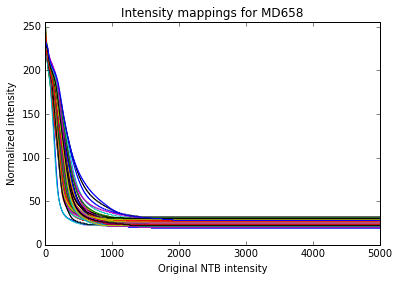

In [12]:
plt.plot(ntb2_blue_bins, np.concatenate(mapping2_all_regions_all_sections.values()).T);
plt.xlabel('Original NTB intensity');
plt.ylabel('Normalized intensity');
plt.ylim([0,256]);
plt.title('Intensity mappings for %s' % stack);
plt.legend();
plt.show();

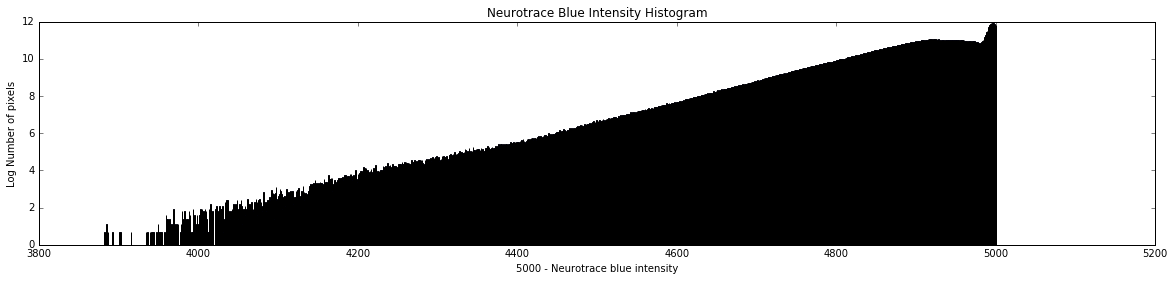

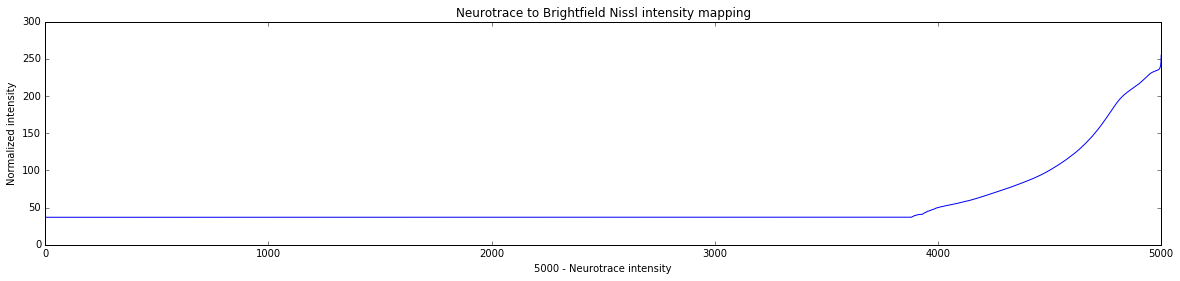

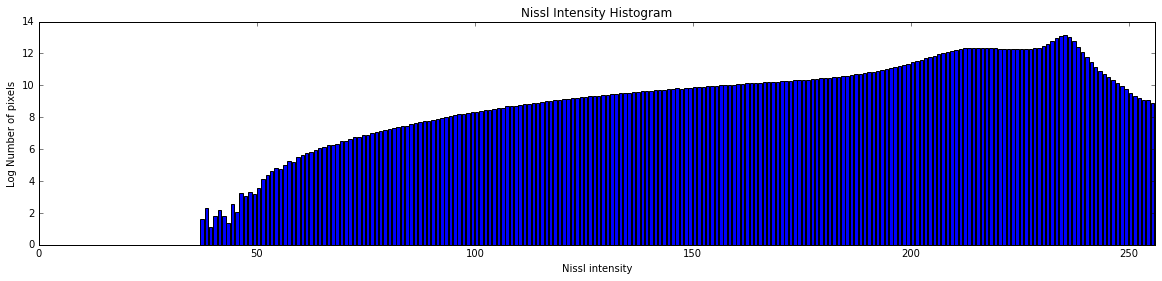

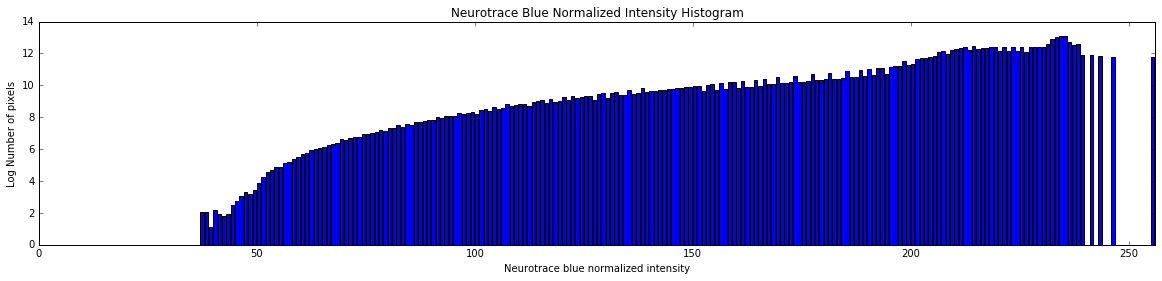

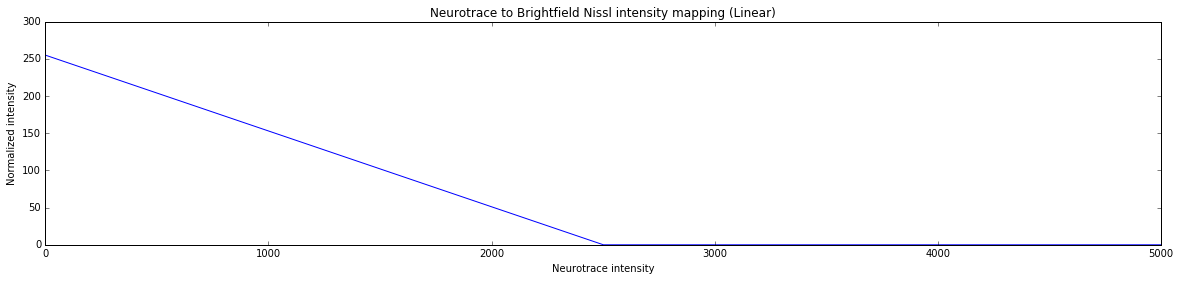

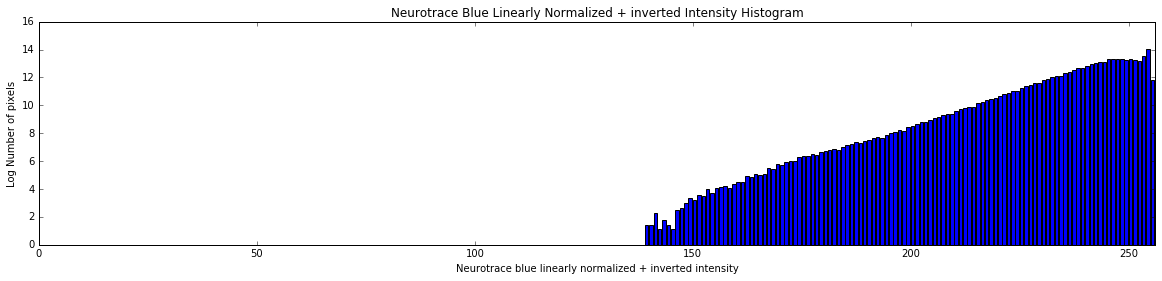

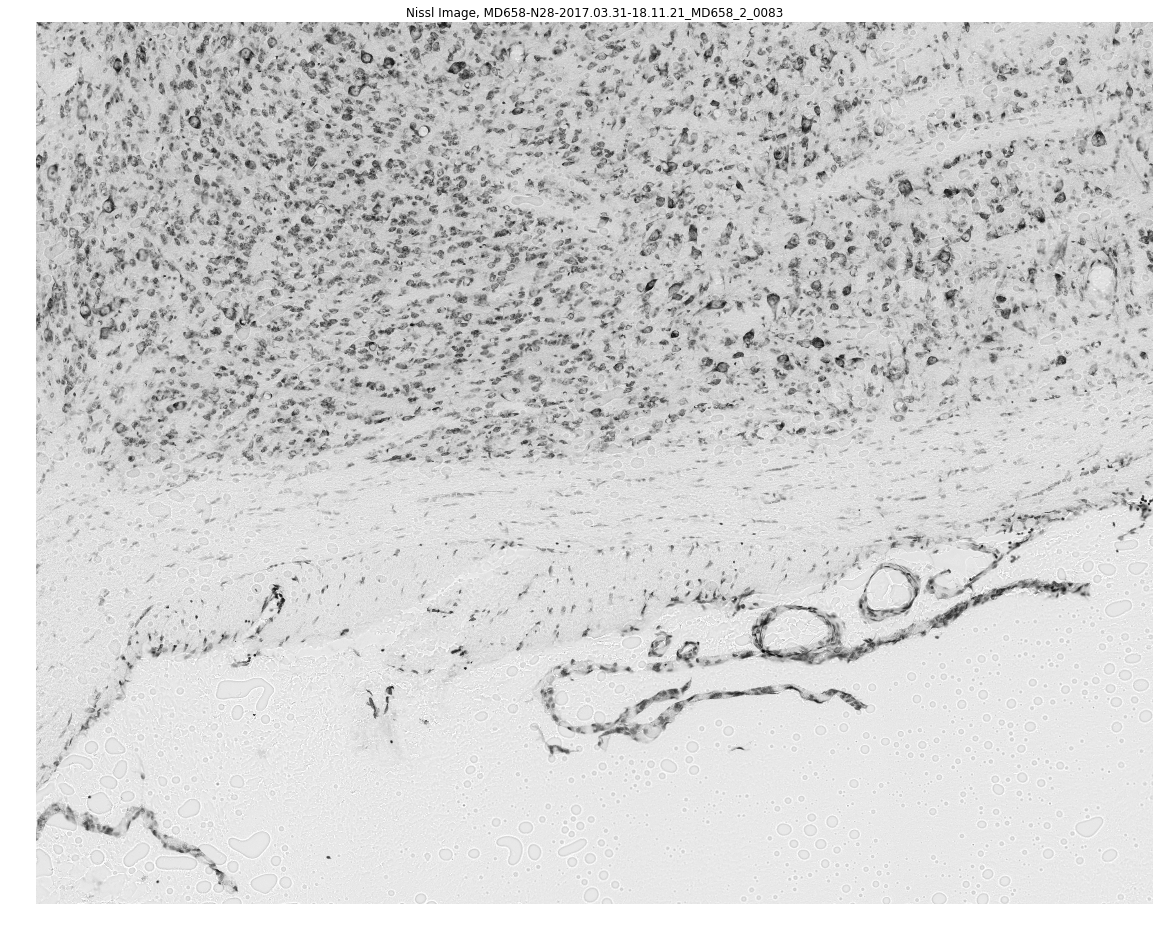

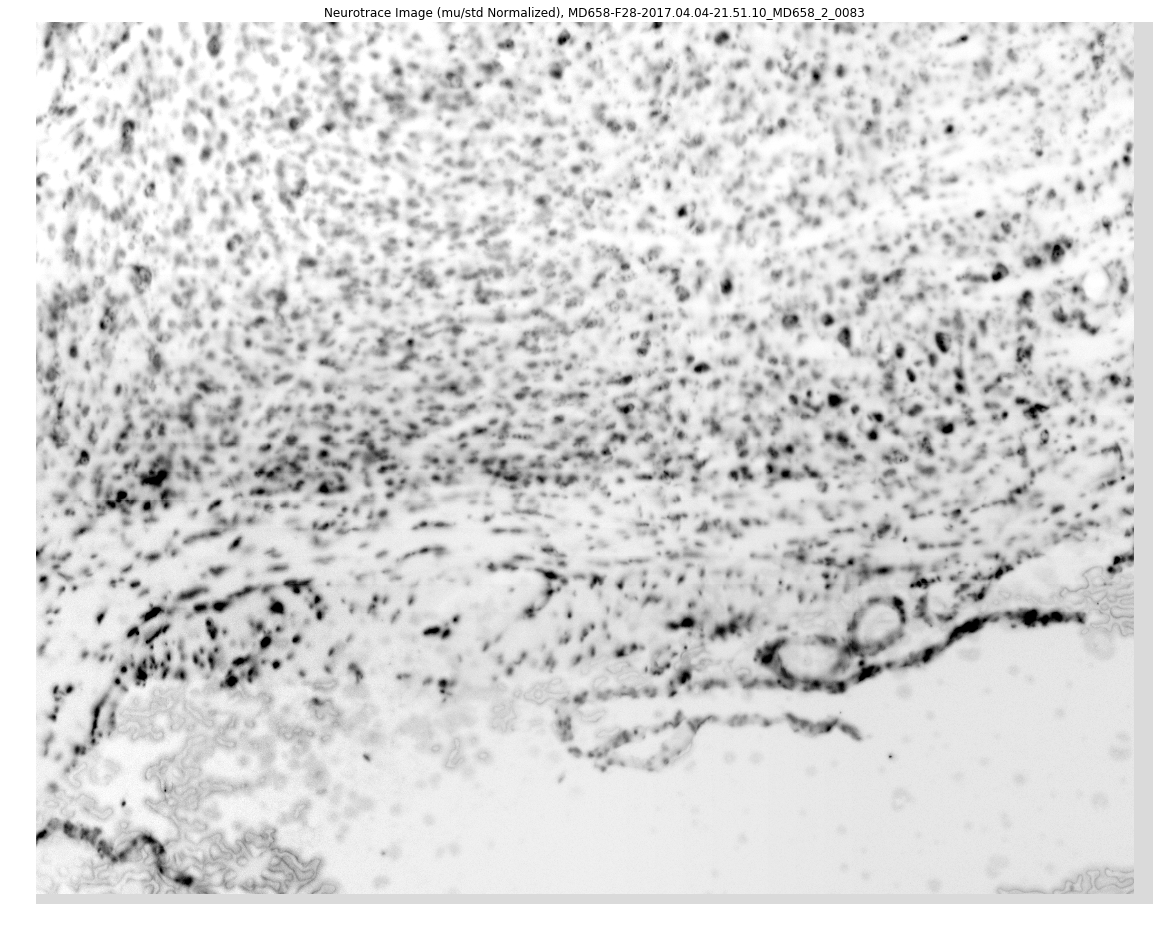

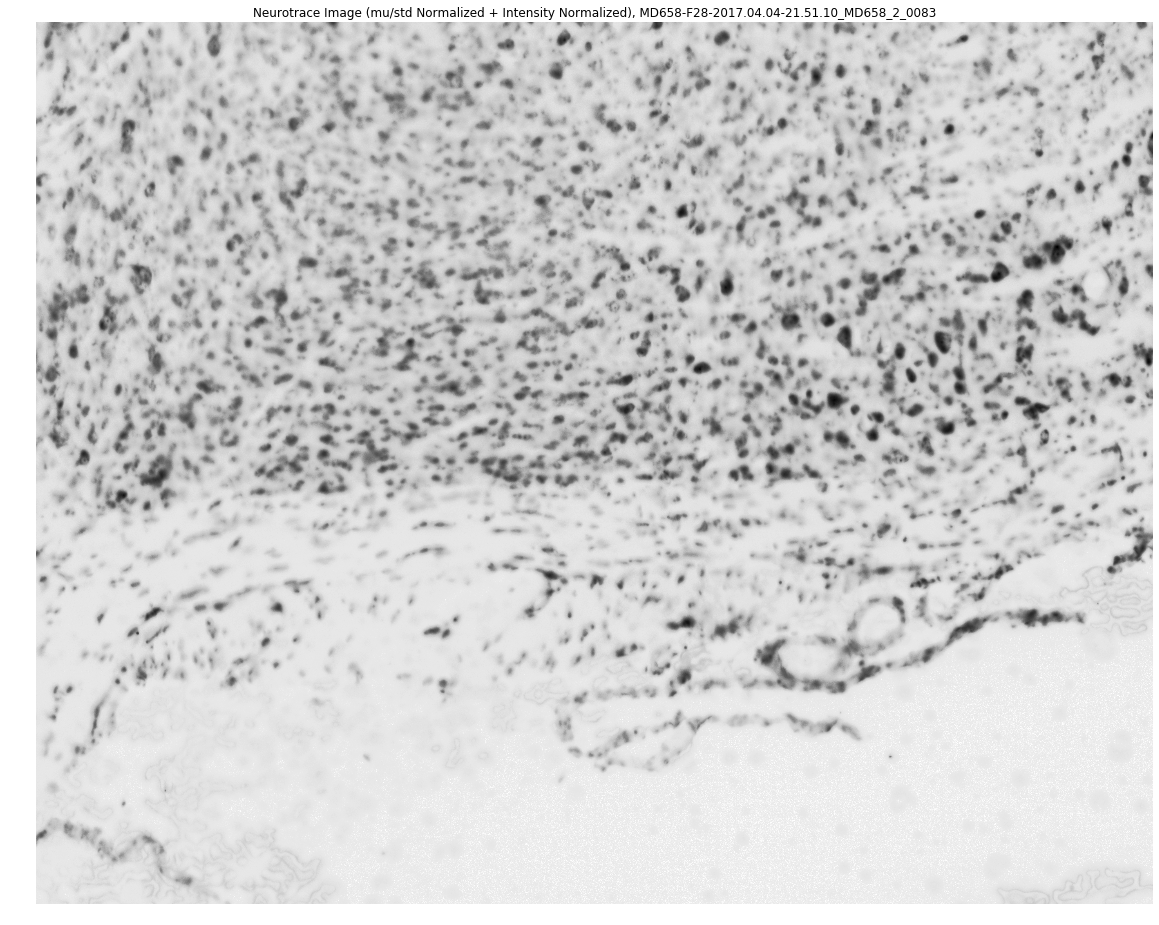

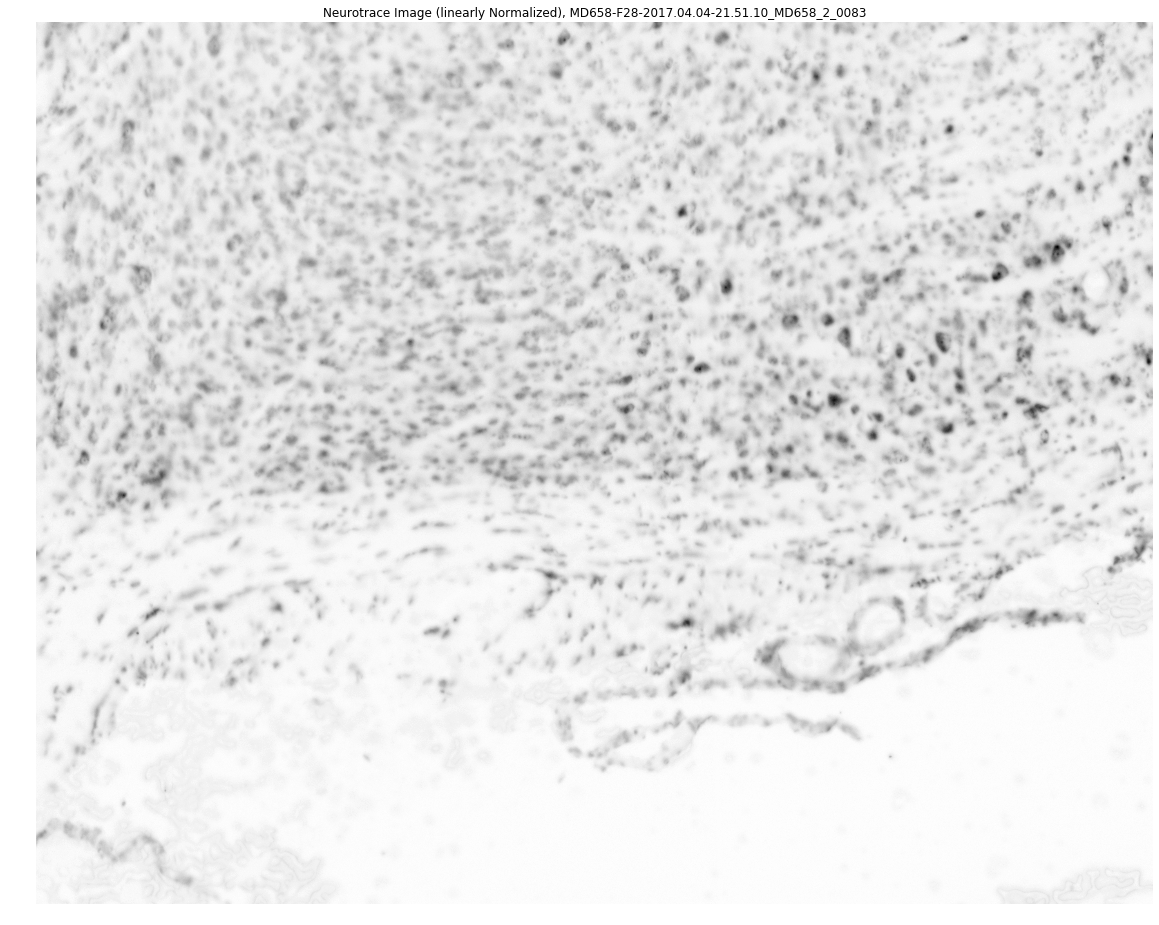

In [119]:
# plt.figure(figsize=(20,4));
# plt.bar(ntb_blue_bins, ntb_blue_hist);
# plt.xlabel('Neurotrace blue intensity');
# plt.ylabel('Number of pixels');
# plt.title('Neurotrace Blue Intensity Histogram');
# plt.show();

# plt.figure(figsize=(20,4));
# plt.bar(ntb_blue_bins, np.log(ntb_blue_hist));
# plt.xlabel('Neurotrace blue intensity');
# plt.ylabel('Log Number of pixels');
# plt.title('Neurotrace Blue Intensity Histogram');
# plt.show();

# plt.figure(figsize=(20,4));
# plt.plot(ntb_blue_bins, ntb_to_nissl_mapping);
# plt.xlabel('Neurotrace intensity');
# plt.ylabel('Normalized intensity');
# plt.title('Neurotrace to Brightfield Nissl intensity mapping');
# plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_inv_bins, np.log(ntb_blue_inv_hist));
plt.xlabel('5000 - Neurotrace blue intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Intensity Histogram');
plt.show();

plt.figure(figsize=(20,4));
plt.plot(ntb_blue_inv_bins, ntb_inv_to_nissl_mapping);
plt.xlabel('5000 - Neurotrace intensity');
plt.ylabel('Normalized intensity');
plt.title('Neurotrace to Brightfield Nissl intensity mapping');
plt.show();

# plt.figure(figsize=(20,4));
# plt.bar(nissl_gray_bins[:-1], nissl_gray_hist);
# plt.xlabel('Nissl intensity');
# plt.ylabel('Number of pixels');
# plt.title('Nissl Intensity Histogram');
# plt.show();

plt.figure(figsize=(20,4));
plt.bar(nissl_gray_bins[:-1], np.log(nissl_gray_hist));
plt.xlabel('Nissl intensity');
plt.ylabel('Log Number of pixels');
plt.title('Nissl Intensity Histogram');
plt.xlim([0,256]);
plt.show();

# plt.figure(figsize=(20,4));
# plt.bar(ntb_blue_normalized_bins, ntb_blue_normalized_hist);
# plt.xlabel('Neurotrace blue normalized intensity');
# plt.ylabel('Number of pixels');
# plt.title('Neurotrace Blue Normalized Intensity Histogram');
# plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_normalized_bins, np.log(ntb_blue_normalized_hist));
plt.xlabel('Neurotrace blue normalized intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Normalized Intensity Histogram');
plt.xlim([0,256]);
plt.show();

plt.figure(figsize=(20,4));
plt.plot(ntb_blue_bins, ntb_to_nissl_linear_mapping);
plt.xlabel('Neurotrace intensity');
plt.ylabel('Normalized intensity');
plt.title('Neurotrace to Brightfield Nissl intensity mapping (Linear)');
plt.show();


# plt.figure(figsize=(20,4));
# plt.bar(ntb_blue_linearNormalized_bins, ntb_blue_linearNormalized_hist);
# plt.xlabel('Neurotrace blue linearly normalized intensity');
# plt.ylabel('Number of pixels');
# plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
# plt.show();

# plt.figure(figsize=(20,4));
# plt.bar(ntb_blue_linearNormalized_bins, np.log(ntb_blue_linearNormalized_hist));
# plt.xlabel('Neurotrace blue linearly normalized intensity');
# plt.ylabel('Log Number of pixels');
# plt.title('Neurotrace Blue Linearly Normalized Intensity Histogram');
# plt.show();

# plt.figure(figsize=(20,4));
# plt.bar(ntb_blue_linearNormalized_inverted_bins, ntb_blue_linearNormalized_inverted_hist);
# plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
# plt.ylabel('Number of pixels');
# plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
# plt.show();

plt.figure(figsize=(20,4));
plt.bar(ntb_blue_linearNormalized_inverted_bins, np.log(ntb_blue_linearNormalized_inverted_hist));
plt.xlabel('Neurotrace blue linearly normalized + inverted intensity');
plt.ylabel('Log Number of pixels');
plt.title('Neurotrace Blue Linearly Normalized + inverted Intensity Histogram');
plt.xlim([0,256]);
plt.show();      


# Separate Figures

plt.figure(figsize=(20,20));
plt.imshow(nissl_region, plt.cm.gray);
plt.title('Nissl Image, %s' % metadata_cache['sections_to_filenames'][stack][nissl_sec]);
plt.axis('off');
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(img_calib_ubyte, plt.cm.gray, vmin=0, vmax=255);
plt.title('Neurotrace Image (mu/std Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
plt.axis('off');
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(ntb_region_normalized, plt.cm.gray);
plt.title('Neurotrace Image (mu/std Normalized + Intensity Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
plt.axis('off');
plt.show();

# plt.figure(figsize=(20,20));
# plt.imshow(ntb_region_linearNormalized, plt.cm.gray);
# plt.title('Neurotrace Image (linearly Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
# plt.axis('off');
# plt.show();

plt.figure(figsize=(20,20));
plt.imshow(ntb_region_linearNormalized_inverted, plt.cm.gray);
plt.title('Neurotrace Image (linearly Normalized), %s' % metadata_cache['sections_to_filenames'][stack][ntb_sec]);
plt.axis('off');
plt.show();

# Subplots
#         fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20,10));
#         axes[0].imshow(nissl_region, plt.cm.gray);
#         axes[0].set_title('Nissl');
#         axes[0].axis('off');

#         axes[1].imshow(ntb_region_inv_normalized, plt.cm.gray);
#         axes[1].set_title('Neurotrace (intensity normalized)');
#         axes[1].axis('off');

#         axes[2].imshow(ntb_region_inv_linearNormalized, plt.cm.gray);
#         axes[2].set_title('Neurotrace (linearly normalized)');
#         axes[2].axis('off');
#         plt.show();